# Vanilla random forest regressor as baseline

In [174]:
from pathlib import Path
import warnings
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb

In [2]:
# Current versions of XGBoost and Seaborn have a FutureWarning bug; suppress with this
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [4]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [257]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

# Split off SMARD forecasted and actuals into separate dataframe and drop SMARD forecasted
df_smard_preds_vs_actuals = df.loc[:, ['forecasted_generation_smard_mwh', 'actual_generated_smard_mwh']].copy()
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

# Add column of pure random noise which will be used for comparison in feature importance analysis later
# Random values between 0 and 1
df['noise'] = np.random.rand(df.shape[0])

# Back fill the 6_550 missing values in day-ahead price feature; random forest regressor doesn't handle NaNs!
df['day_ahead_price_eur_mwh'].fillna(method='bfill', inplace=True)

# Drop total_nominal_capacity_smard_mw as it has yearly temporal resolution and my version has quasi-daily
df.drop(columns=['total_nominal_capacity_smard_mw'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48168 entries, 2018-01-01 00:00:00+00:00 to 2023-06-30 23:00:00+00:00
Data columns (total 34 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   hour                                            48168 non-null  int32   
 1   day_of_week                                     48168 non-null  int32   
 2   day_of_month                                    48168 non-null  int32   
 3   day_of_year                                     48168 non-null  int32   
 4   week_of_year                                    48168 non-null  int32   
 5   month_number                                    48168 non-null  int32   
 6   year                                            48168 non-null  int32   
 7   meteorological_season                           48168 non-null  category
 8   public_holiday                                  48168 non-n

#### Separate unweighted and weighted ERA5 features into separate dataframes

In [258]:
# Separate these ERA5 and ERA5-derived param groups for quicker selections later

# My 9 weighted ERA5 features
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_wind_gusts_10m',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

# My 9 unweighted ERA5 features
unweighted_wx_features = [
    'temp_2m_celsius',
    'mean_sea_level_pressure_mb',
    'wind_gusts_10m',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes as well
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

-----

#### Remove columns to test feature and permutation importance

In [259]:
df_weighted.drop(columns=
                 ['weighted_mean_wind_speed_100m',
                  'weighted_mean_wind_speed_10m',
                  'weighted_wind_gusts_10m',
                  'residual_load_smard_mwh',
                 ], inplace=True)

df_unweighted.drop(columns=
                   ['mean_wind_speed_100m',
                    'mean_wind_speed_10m',
                    'wind_gusts_10m',
                    'residual_load_smard_mwh',
                   ], inplace=True)

-----

## Somewhat "vanilla" random forest regressor
- This is just to set a baseline RMSE score that I can improve upon using more advanced techniques
- I've chosen the start of 2023 at my split point
    - That means c. 90% train data and c. 10% test data

#### Plot the train and test split to better visualise the split

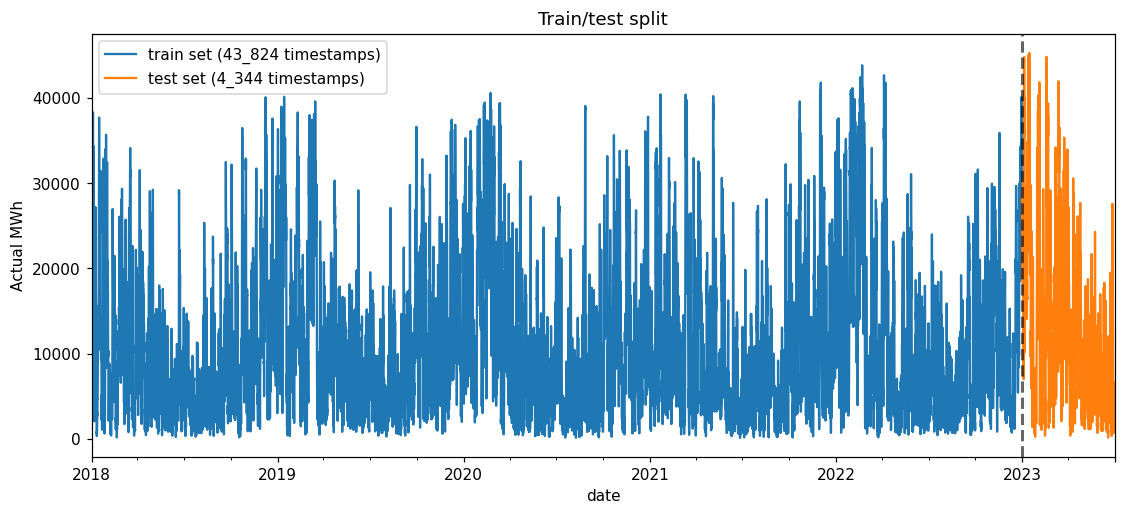

In [260]:
split_date = '2023-01-01'

# Separate train and test sets on chosen date
train_set = df.loc[df.index < split_date]
test_set = df.loc[df.index >= split_date]

# Plot the split
fig, ax = plt.subplots(figsize=(12,5))

train_set['actual_generated_smard_mwh'].plot(ax=ax, label='training set', title='Train/test split')
test_set['actual_generated_smard_mwh'].plot(ax=ax, label='test set')

ax.axvline('2023-01-01', color='black', ls='--', linewidth=2, alpha=0.6)
ax.legend(['train set (43_824 timestamps)', 'test set (4_344 timestamps)'])
ax.set_xlabel('date')
ax.set_ylabel('Actual MWh')

plt.show()

#### Function that assigns X & y and creates a pipeline with a column transformer and random forest regressor as steps

In [261]:
def create_pipeline_and_sets_using_df(df, split_date='2023-01-01'):
    """
    Input is either the unweighted or weighted dataframe
    Output is the pipeline object and X & y train-test sets
    """
    # Separate train and test sets on chosen date
    train_set = df.loc[df.index < split_date].copy()
    test_set = df.loc[df.index >= split_date].copy()

    # Assign my train sets
    X_train = train_set.drop(columns=['actual_generated_smard_mwh'])
    y_train = train_set['actual_generated_smard_mwh']

    # Assign my test sets
    X_test = test_set.drop(columns=['actual_generated_smard_mwh'])
    y_test = test_set['actual_generated_smard_mwh']

    # List of categorical features for ordinal encoding
    # Get from df as column names depend on if using weighted or unweighted df
    categorical_features = df.select_dtypes('category').columns.to_list()

    # the unique values for each categorical feature; must be in order of list above
    categories = [
        # meteorological_season
        ['winter', 'spring', 'summer', 'autumn'],
        # wind_direction_intercardinal_10m
        ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
         'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
        # wind_direction_intercardinal_100m
        ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
         'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
    ]

    # Instantiate ordinal encoder and provide unique categories (could also use defaul of auto)
    ordinal_encoder = OrdinalEncoder(categories=categories)

    # Create pipeline object with named steps
    rf_pipeline = Pipeline([
        # Step 1: run categorical features through ordinal encoder
        ('transformer',
            ColumnTransformer(
            transformers=[
                ('categorical', ordinal_encoder, categorical_features),
            ],
            remainder='passthrough',
            verbose_feature_names_out=False,
        )),
        # Step 2: instantiate random forest regressor
        ('model', RandomForestRegressor(
            n_estimators=50,
            max_depth=8,
            verbose=0,
            n_jobs=-1,
        )),
    ], verbose=2).set_output(transform='pandas')
    
    return rf_pipeline, X_train, y_train, X_test, y_test

#### Create function to fit and score the pipeline/model

In [262]:
def fit_and_score_model(pipeline, X_train, y_train, X_test, y_test):
    # fit model to the train data (via pipeline object)
    rf_pipeline.fit(X_train, y_train)
    # make target predictions using test set
    y_preds = rf_pipeline.predict(X_test)
    # calculate RMSE error of predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print(f'RMSE of model predictions: {rmse:.2f}')
    # return pipeline with fitted model inside
    return rf_pipeline

#### Run the function and get RMSE score of test set for both `df_unweighted` and `df_weighted`

##### RMSE score using `df_unweighted`

In [263]:
# Create pipeline and X & y train/test sets
rf_pipeline, X_train, y_train, X_test, y_test = create_pipeline_and_sets_using_df(df_unweighted)
# Fit and score my model
rf_pipeline_unweighted = fit_and_score_model(rf_pipeline, X_train, y_train, X_test, y_test)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.7s
RMSE of model predictions: 7728.37


##### RMSE score using `df_weighted`

In [264]:
# Create pipeline and X & y train/test sets
rf_pipeline, X_train, y_train, X_test, y_test = create_pipeline_and_sets_using_df(df_weighted)
# Fit and score my model
rf_pipeline_weighted = fit_and_score_model(rf_pipeline, X_train, y_train, X_test, y_test)

[Pipeline] ....... (step 1 of 2) Processing transformer, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.7s
RMSE of model predictions: 7547.32


------

## Feature and permutation importances

In [265]:
def get_feature_and_permutation_importances(pipeline, df, n_repeats=10):
    fitted_model = pipeline['model']
    # Get model's feature names in
    feature_names = fitted_model.feature_names_in_
    # Get model's feature importances
    feature_importances = fitted_model.feature_importances_
    
    X = df.drop(columns=['actual_generated_smard_mwh']).copy()
    # Run X through ordinal encoding to prep for permutation importance
    X_transformed = pipeline['transformer'].fit_transform(X)
    y = df['actual_generated_smard_mwh'].copy()
    
    # Verify that feature names are in the same order
    print(f'Feature names equal: {np.array_equal(feature_names, np.array(X_transformed.columns))}')
    
    # Calculate permutation importances on the already-fitted model
    permutation_result = permutation_importance(
        fitted_model, 
        X_transformed, 
        y,
        scoring='neg_root_mean_squared_error',
        n_repeats=n_repeats, 
        random_state=0
    )
    
    # Create pandas df of mean permutation importances and their standard deviations
    df_importances = pd.DataFrame(data={
        'feature_importances': feature_importances,
        'permutation_importances_mean': permutation_result.importances_mean,
        'permutation_importances_std': permutation_result.importances_std
    }, index=feature_names)
    
    # Min-max normalise for better visualisation
    df_importances[['feature_importances_norm', 'permutation_importances_mean_norm']] = MinMaxScaler().fit_transform(
    df_importances[['feature_importances', 'permutation_importances_mean']]
    )
    
    # Sort dataframe for plotting
    df_importances.sort_values(by='permutation_importances_mean', ascending=True, inplace=True)
    # Round all values to better display as bar labels in plot
    df_importances = df_importances.applymap(lambda x: round(x, 4))
    
    return df_importances

In [266]:
df_importances_unweighted = get_feature_and_permutation_importances(
    rf_pipeline_unweighted,
    df_unweighted,
    n_repeats=10
)

Feature names equal: True


In [267]:
df_importances_unweighted

,feature_importances,permutation_importances_mean,permutation_importances_std,feature_importances_norm,permutation_importances_mean_norm
public_holiday,0.0000,0.0001,0.0000,0.0000,0.0000
noise,0.0002,0.4809,0.0989,0.0007,0.0002
wind_direction_intercardinal_100m,0.0006,2.2577,0.1902,0.0020,0.0010
meteorological_season,0.0012,5.7968,0.3785,0.0043,0.0025
wind_direction_intercardinal_10m,0.0010,6.7700,0.2814,0.0036,0.0030
year,0.0022,7.9942,1.2866,0.0079,0.0035
day_of_week,0.0052,34.5656,0.8240,0.0187,0.0151
month_number,0.0090,42.8846,1.3504,0.0322,0.0188
day_of_month,0.0102,74.0235,1.6361,0.0364,0.0324
hour,0.0074,80.8472,1.7432,0.0264,0.0354


In [268]:
df_importances_weighted = get_feature_and_permutation_importances(
    rf_pipeline_weighted,
    df_weighted,
    n_repeats=10
)

Feature names equal: True


In [269]:
df_importances_weighted

,feature_importances,permutation_importances_mean,permutation_importances_std,feature_importances_norm,permutation_importances_mean_norm
public_holiday,0.0000,0.0015,0.0000,0.0000,0.0000
noise,0.0001,0.3247,0.0187,0.0005,0.0002
weighted_wind_direction_intercardinal_100m,0.0006,2.6530,0.1707,0.0021,0.0012
weighted_wind_direction_intercardinal_10m,0.0009,5.2120,0.3033,0.0033,0.0024
year,0.0031,15.9761,1.4274,0.0115,0.0074
day_of_week,0.0058,39.1394,1.0903,0.0218,0.0183
meteorological_season,0.0078,40.9545,1.4176,0.0294,0.0191
day_of_month,0.0106,66.9221,1.2932,0.0397,0.0312
hour,0.0071,77.2021,1.2312,0.0265,0.0360
turbines_in_operation,0.0203,115.5398,4.7018,0.0759,0.0539


In [282]:
def plot_importances(df):
    fig, ax = plt.subplots(figsize=(10, 7))
    # df['permutation_importances_mean'].plot.barh(xerr=df['permutation_importances_std'], ax=ax)
    df[['feature_importances_norm', 'permutation_importances_mean_norm']].plot.barh(ax=ax)
    ax.set_title('Feature and permutation importances')
    ax.set_xlabel('Importance (normalised)')

    # ax.bar_label(
    #     ax.containers[1],
    #     labels=df['permutation_importances_mean'], 
    #     padding=5,
    #     fontsize=8,
    #     color='tab:blue',
    # )
    # ax.set_xlim(right=df['permutation_importances_mean'].max()+1000)
    
    ax.legend(loc='center right')
    fig.tight_layout()
    plt.show()

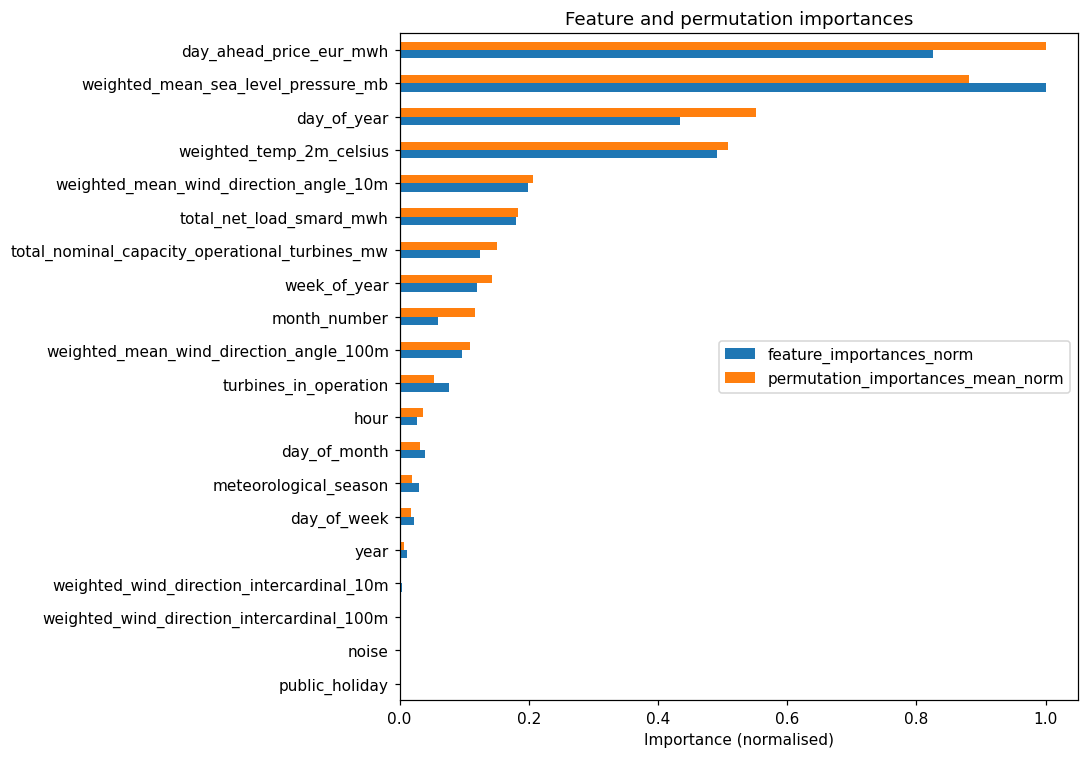

In [283]:
plot_importances(df_importances_weighted)

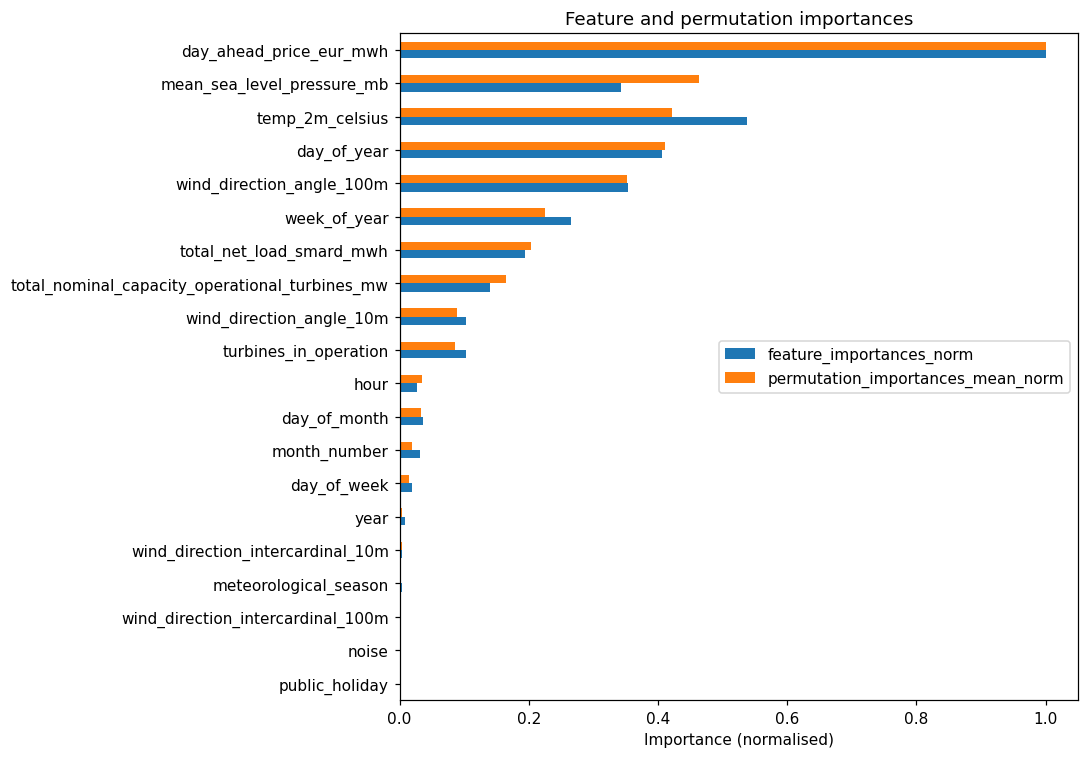

In [284]:
plot_importances(df_importances_unweighted)